In [1]:
# load dataset
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()
dataset = loader.get_dataset(lags=14)

In [2]:
# split dataset
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [3]:
# define model
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [4]:
# train model
from tqdm import tqdm

model = RecurrentGCN(node_features=14, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(5)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 5/50 [02:05<18:52, 25.16s/it]


KeyboardInterrupt: 

In [5]:
# evaluate model
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost += torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print('MSE: {:.4f}'.format(cost))

MSE: 1.3633


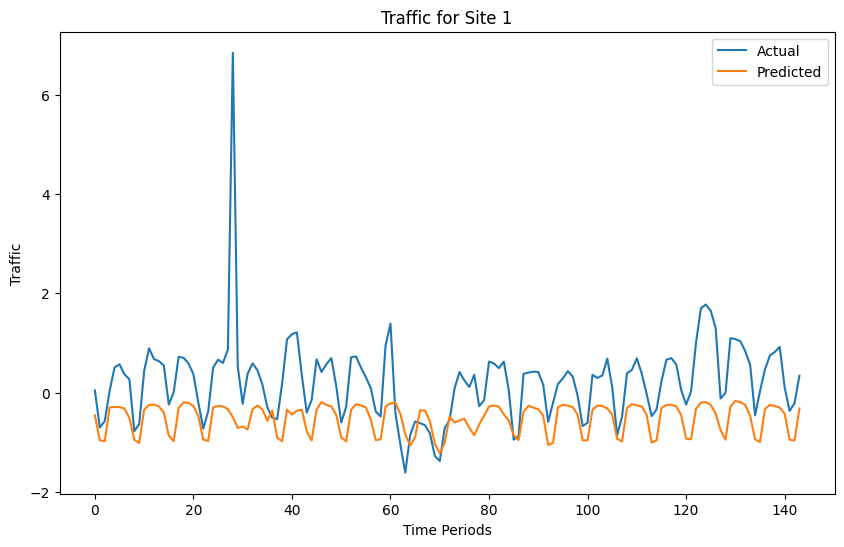

In [7]:
import matplotlib.pyplot as plt

# Let's assume we are visualizing for the first site
site_index = 0 

# Extract actual and predicted values for the site
actual_values = []
predicted_values = []

model.eval()
for snapshot in test_dataset:
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    actual_values.append(snapshot.y.numpy()[site_index])
    predicted_values.append(y_hat.detach().numpy()[site_index])

# Generate a sequence of dates or time periods
# assuming that each snapshot corresponds to a day
time_periods = range(len(actual_values))

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(time_periods, actual_values, label='Actual')
plt.plot(time_periods, predicted_values, label='Predicted')

plt.title(f'Traffic for Site {site_index+1}')
plt.xlabel('Time Periods')
plt.ylabel('Traffic')
plt.legend()

plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define lists to store the MSE for each site
mse_values = []

# Assuming the number of sites equals to the first dimension of y
num_sites = test_dataset[0].y.shape[0]

model.eval()
for site_index in range(num_sites):
    actual_values = []
    predicted_values = []

    for snapshot in test_dataset:
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        actual_values.append(snapshot.y.numpy()[site_index])
        predicted_values.append(y_hat.detach().numpy()[site_index])

    mse = mean_squared_error(actual_values, predicted_values)
    mse_values.append(mse)

# Generate a sequence of site indices
site_indices = range(1, num_sites + 1)

# Create the plot
plt.figure(figsize=(10,6))
plt.bar(site_indices, mse_values)

plt.title('MSE for Each Site')
plt.xlabel('Site Index')
plt.ylabel('MSE')
plt.show()